# Exploring and Visualizing OpenAQ Data

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import openaq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
sns.set_theme(style="darkgrid")

from shapely.geometry import Point

import geopandas as gpd
from geopandas import GeoDataFrame

import geoplot as gplt
import geoplot.crs as gcrs

import fiona

import imageio
import os

import viz_utils as vu

ERROR 1: PROJ: proj_create_from_database: Open of /home/jovyan/envs/aqproject/share/proj failed


In [2]:
api = openaq.OpenAQ()
resp = api.cities(df=True, limit=10000)

In [3]:
resp.query('city.str.contains("San") and country.str.contains("US")', engine='python')

country                              name  \
145       US    Atlanta-Sandy Springs-Marietta   
1383      US  Los Angeles-Long Beach-Santa Ana   
2028      US  Riverside-San Bernardino-Ontario   
2094      US                       San Antonio   
2102      US     San Diego-Carlsbad-San Marcos   
2108      US            San Francisco Bay Area   
2109      US     San Francisco-Oakland-Fremont   
2111      US    San Jose-Sunnyvale-Santa Clara   
2114      US          San Juan-Caguas-Guaynabo   
2121      US       San Luis Obispo-Paso Robles   
2126      US         Santa Barbara-Santa Maria   
2129      US            Santa Cruz-Watsonville   
2131      US                          Santa Fe   
2134      US               Santa Rosa-Petaluma   

                                  city    count  locations  
145     Atlanta-Sandy Springs-Marietta  1904856         13  
1383  Los Angeles-Long Beach-Santa Ana  5564334         32  
2028  Riverside-San Bernardino-Ontario  5440257         42  
2094                       San Antonio   514007          8  
2102     San Diego-Carlsbad-San Marcos  1007345         11  
2108            San Francisco Bay Area   152929          1  
2109     San Francisco-Oakland-Fremont  4657516         15  
2111    San Jose-Sunnyvale-Santa Clara  1313034          8  
2114          San Juan-Caguas-Guaynabo     8475          1  
2121       San Luis Obispo-Paso Robles  1613408         34  
2126         Santa Barbara-Santa Maria  2072849         18  
2129            Santa Cruz-Watsonville   257826          8  
2131                          Santa Fe   196562          1  
2134               Santa Rosa-Petaluma   370990          1

In [4]:
res = api.locations(city='San Francisco-Oakland-Fremont', df=True)

<AxesSubplot:>

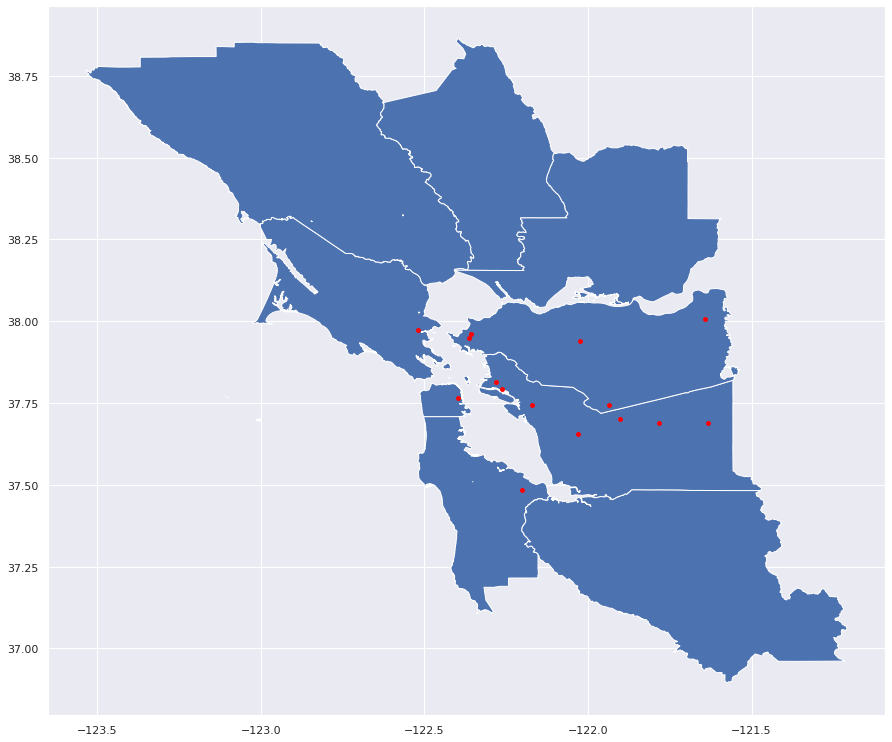

In [5]:
geometry = [Point(xy) for xy in zip(res['coordinates.longitude'], res['coordinates.latitude'])]
gdf = GeoDataFrame(res, geometry=geometry)
world = gpd.read_file("https://data.sfgov.org/api/geospatial/s9wg-vcph?method=export&format=Shapefile")
gdf.plot(ax=world.plot(figsize=(15, 15)), marker='o', color='red', markersize=15)

In [6]:
measure = api.measurements(city='San Francisco-Oakland-Fremont', parameter='pm25', limit=1000, df=True)

# Print out the statistics on a per-location basiss
measure.groupby(['location'])['value'].describe()

count       mean       std  min  25%  50%   75%   max
location                                                                   
Concord               103.0   5.291262  2.358261 -1.0  4.0  5.0   7.0  11.0
Laney College          74.0   5.635135  2.248740  0.0  4.0  6.0   7.0  10.0
Livermore - Rincon    101.0   4.940594  2.436480  0.0  3.0  4.0   7.0  12.0
Oakland               103.0   5.689320  2.062880  1.0  4.0  6.0   7.0  11.0
Oakland West          104.0   4.769231  2.398344 -1.0  3.0  5.0   7.0  11.0
Pleasanton - Owens C  103.0   5.533981  2.750456 -1.0  4.0  5.0   7.0  14.0
Redwood City          103.0   4.116505  3.059223 -3.0  2.0  4.0   5.0  15.0
San Francisco         104.0   5.471154  3.249964 -1.0  3.0  6.0   8.0  17.0
San Pablo - Rumrill   101.0  10.495050  8.107557  3.0  6.0  8.0  11.0  43.0
San Rafael            104.0   4.855769  2.521435 -2.0  3.0  5.0   6.0  12.0

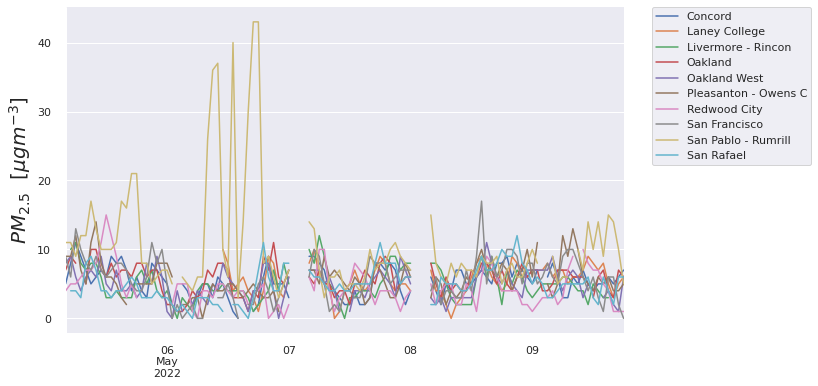

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 6))

for group, df in measure.groupby('location'):
    # Query the data to only get positive values and resample to hourly
    _df = df.query("value >= 0.0").resample('1h').mean()

    _df.value.plot(ax=ax, label=group)

ax.legend(loc='best')
ax.set_ylabel("$PM_{2.5}$  [$\mu g m^{-3}$]", fontsize=20)
ax.set_xlabel("")
sns.despine(offset=5)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

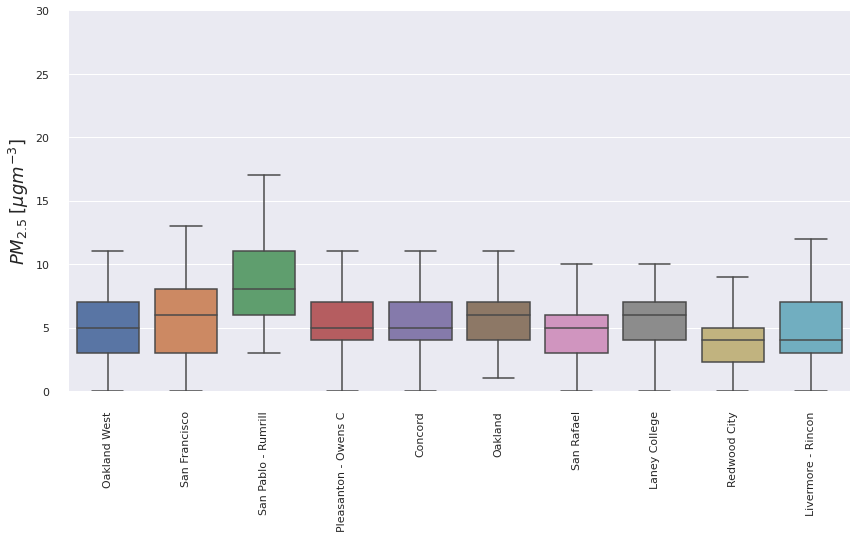

In [8]:
fig, ax = plt.subplots(1, figsize=(14,7))

ax = sns.boxplot(
    x='location',
    y='value',
    data=measure.query("value >= 0.0"),
    fliersize=0,
    palette='deep',
    ax=ax)

ax.set_ylim([0, 30])
ax.set_ylabel("$PM_{2.5}\;[\mu gm^{-3}]$", fontsize=18)
ax.set_xlabel("")

sns.despine(offset=10)

plt.xticks(rotation=90)
plt.show()

In [9]:
sanfrancisco = api.locations(city='San Francisco-Oakland-Fremont', df=True)


sanfrancisco.iloc[0]


id                                                                    1311
country                                                                 US
city                                         San Francisco-Oakland-Fremont
cities                                     [San Francisco-Oakland-Fremont]
location                                                     Laney College
locations                                                  [Laney College]
sourceName                                                          AirNow
sourceNames                                                       [AirNow]
sourceType                                                      government
sourceTypes                                                   [government]
firstUpdated                                     2016-03-06 19:00:00+00:00
lastUpdated                                      2022-05-10 01:00:00+00:00
parameters                                             [bc, pm25, co, no2]
countsByMeasurement      

In [10]:
dark_day_sf_pm25 = api.measurements(location='San Francisco', parameter='pm25', date_from='2020-09-07', date_to='2020-09-13', df=True, limit=1000)
dark_day_sf_pm25.head()

location parameter  value                    unit  \
date.local                                                                    
2020-09-12 17:00:00  San Francisco      pm25     77  b'\xc2\xb5g/m\xc2\xb3'   
2020-09-12 16:00:00  San Francisco      pm25     78  b'\xc2\xb5g/m\xc2\xb3'   
2020-09-12 15:00:00  San Francisco      pm25     77  b'\xc2\xb5g/m\xc2\xb3'   
2020-09-12 14:00:00  San Francisco      pm25     83  b'\xc2\xb5g/m\xc2\xb3'   
2020-09-12 13:00:00  San Francisco      pm25     87  b'\xc2\xb5g/m\xc2\xb3'   

                    country                           city  \
date.local                                                   
2020-09-12 17:00:00      US  San Francisco-Oakland-Fremont   
2020-09-12 16:00:00      US  San Francisco-Oakland-Fremont   
2020-09-12 15:00:00      US  San Francisco-Oakland-Fremont   
2020-09-12 14:00:00      US  San Francisco-Oakland-Fremont   
2020-09-12 13:00:00      US  San Francisco-Oakland-Fremont   

                                     date.utc  coordinates.latitude  \
date.local                                                            
2020-09-12 17:00:00 2020-09-13 00:00:00+00:00               37.7658   
2020-09-12 16:00:00 2020-09-12 23:00:00+00:00               37.7658   
2020-09-12 15:00:00 2020-09-12 22:00:00+00:00               37.7658   
2020-09-12 14:00:00 2020-09-12 21:00:00+00:00               37.7658   
2020-09-12 13:00:00 2020-09-12 20:00:00+00:00               37.7658   

                     coordinates.longitude  
date.local                                  
2020-09-12 17:00:00              -122.3978  
2020-09-12 16:00:00              -122.3978  
2020-09-12 15:00:00              -122.3978  
2020-09-12 14:00:00              -122.3978  
2020-09-12 13:00:00              -122.3978

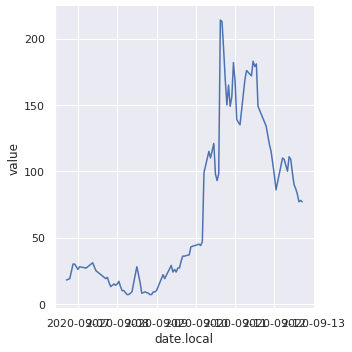

In [11]:
g = sns.relplot(x=dark_day_sf_pm25.index, y='value', kind='line', data=dark_day_sf_pm25)
#g.set(xticks=range(len(dark_day_sf_pm25.index)+1))

In [12]:
dark_max = dark_day_sf_pm25[dark_day_sf_pm25.value == dark_day_sf_pm25.value.max()]
dark_max

location parameter  value                    unit  \
date.local                                                                    
2020-09-10 15:00:00  San Francisco      pm25    214  b'\xc2\xb5g/m\xc2\xb3'   

                    country                           city  \
date.local                                                   
2020-09-10 15:00:00      US  San Francisco-Oakland-Fremont   

                                     date.utc  coordinates.latitude  \
date.local                                                            
2020-09-10 15:00:00 2020-09-10 22:00:00+00:00               37.7658   

                     coordinates.longitude  
date.local                                  
2020-09-10 15:00:00              -122.3978

In [13]:
test = api.measurements(city='San Francisco-Oakland-Fremont', date_from='2020-09-07', date_to='2020-09-08', df=True, limit=1000)
test = test[test['parameter'] == 'pm25']
test = test[test['date.utc'] == '2020-09-07 13:00:00+00:00']
test

location parameter  value  \
date.local                                                   
2020-09-07 06:00:00               Concord      pm25   21.0   
2020-09-07 06:00:00         Laney College      pm25   21.0   
2020-09-07 06:00:00    Livermore - Rincon      pm25   30.0   
2020-09-07 06:00:00          Redwood City      pm25   30.0   
2020-09-07 06:00:00          Oakland West      pm25   21.0   
2020-09-07 06:00:00            San Rafael      pm25   18.0   
2020-09-07 06:00:00               Oakland      pm25   21.0   
2020-09-07 06:00:00  Pleasanton - Owens C      pm25   32.0   
2020-09-07 06:00:00   San Pablo - Rumrill      pm25   16.0   
2020-09-07 06:00:00         San Francisco      pm25   28.0   

                                       unit country  \
date.local                                            
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   

                                              city                  date.utc  \
date.local                                                                     
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   

                     coordinates.latitude  coordinates.longitude  
date.local                                                        
2020-09-07 06:00:00             37.938300            -122.025000  
2020-09-07 06:00:00             37.793624            -122.263376  
2020-09-07 06:00:00             37.687526            -121.784217  
2020-09-07 06:00:00             37.482800            -122.202200  
2020-09-07 06:00:00             37.814800            -122.282402  
2020-09-07 06:00:00             37.972200            -122.518900  
2020-09-07 06:00:00             37.743061            -122.169907  
2020-09-07 06:00:00             37.701222            -121.903019  
2020-09-07 06:00:00             37.960400            -122.357100  
2020-09-07 06:00:00             37.765800            -122.397800

In [14]:
geometry = [Point(xy) for xy in zip(test['coordinates.longitude'], test['coordinates.latitude'])]
gdf = GeoDataFrame(test, geometry=geometry)

gdf


location parameter  value  \
date.local                                                   
2020-09-07 06:00:00               Concord      pm25   21.0   
2020-09-07 06:00:00         Laney College      pm25   21.0   
2020-09-07 06:00:00    Livermore - Rincon      pm25   30.0   
2020-09-07 06:00:00          Redwood City      pm25   30.0   
2020-09-07 06:00:00          Oakland West      pm25   21.0   
2020-09-07 06:00:00            San Rafael      pm25   18.0   
2020-09-07 06:00:00               Oakland      pm25   21.0   
2020-09-07 06:00:00  Pleasanton - Owens C      pm25   32.0   
2020-09-07 06:00:00   San Pablo - Rumrill      pm25   16.0   
2020-09-07 06:00:00         San Francisco      pm25   28.0   

                                       unit country  \
date.local                                            
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   
2020-09-07 06:00:00  b'\xc2\xb5g/m\xc2\xb3'      US   

                                              city                  date.utc  \
date.local                                                                     
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   
2020-09-07 06:00:00  San Francisco-Oakland-Fremont 2020-09-07 13:00:00+00:00   

                     coordinates.latitude  coordinates.longitude  \
date.local                                                         
2020-09-07 06:00:00             37.938300            -122.025000   
2020-09-07 06:00:00             37.793624            -122.263376   
2020-09-07 06:00:00             37.687526            -121.784217   
2020-09-07 06:00:00             37.482800            -122.202200   
2020-09-07 06:00:00             37.814800            -122.282402   
2020-09-07 06:00:00             37.972200            -122.518900   
2020-09-07 06:00:00             37.743061            -122.169907   
2020-09-07 06:00:00             37.701222            -121.903019   
2020-09-07 06:00:00             37.960400            -122.357100   
2020-09-07 06:00:00             37.765800            -122.397800   

                                        geometry  
date.local                                        
2020-09-07 06:00:00  POINT (-122.02500 37.93830)  
2020-09-07 06:00:00  POINT (-122.26338 37.79362)  
2020-09-07 06:00:00  POINT (-121.78422 37.68753)  
2020-09-07 06:00:00  POINT (-122.20220 37.48280)  
2020-09-07 06:00:00  POINT (-122.28240 37.81480)  
2020-09-07 06:00:00  POINT (-122.51890 37.97220)  
2020-09-07 06:00:00  POINT (-122.16991 37.74306)  
2020-09-07 06:00:00  POINT (-121.90302 37.70122)  
2020-09-07 06:00:00  POINT (-122.35710 37.96040)  
2020-09-07 06:00:00  POINT (-122.39780 37.76580)

Text(0.5, 1.0, 'Bay Area pm25 on ')

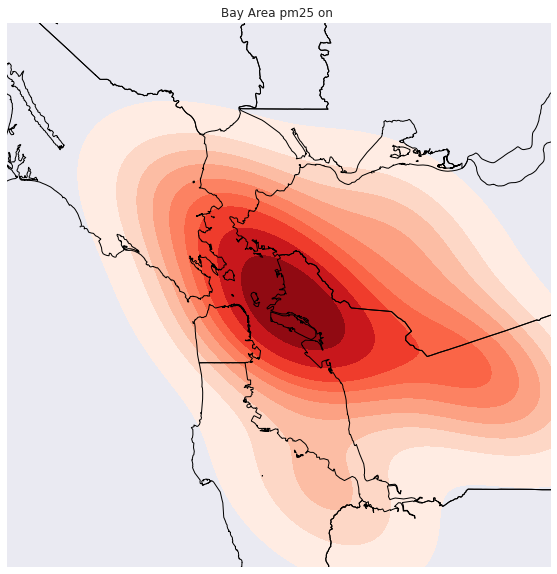

In [15]:
proj = gcrs.AlbersEqualArea(central_latitude=37.8711428, central_longitude=-122.3714777)
fig= plt.figure(figsize=(10, 10))
ax1 = plt.subplot(111, projection=proj)

gplt.kdeplot(
    gdf,
    cmap='Reds',
    projection=proj,
    shade=True, thresh=0.05,
    ax=ax1
)
gplt.polyplot(world, zorder=1, ax=ax1)
ax1.axis(xmin=-50000,xmax=60000, ymin=-60000, ymax=50000)
ax1.set_title("Bay Area pm25 on ")

In [16]:
USlocs = api.locations(country='US', df=True, limit=10000)

USlocs.head()

id country                       city                       cities  \
0  212      US                 Fort Smith                 [Fort Smith]   
1  213      US                 TWIN FALLS                 [TWIN FALLS]   
2  215      US                    TUSCOLA                    [TUSCOLA]   
3  216      US       South Bend-Mishawaka       [South Bend-Mishawaka]   
4  218      US  Chicago-Naperville-Joliet  [Chicago-Naperville-Joliet]   

               location                                locations sourceName  \
0                ROLAND                                 [ROLAND]     AirNow   
1       Twin Falls PM25  [Twin Falls 1405 TEOM, Twin Falls PM25]     AirNow   
2            Unionville                             [Unionville]     AirNow   
3  South Bend-Shields D                   [South Bend-Shields D]     AirNow   
4           Ogden Dunes                            [Ogden Dunes]     AirNow   

  sourceNames  sourceType   sourceTypes              firstUpdated  \
0    [AirNow]  government  [government] 2016-03-06 19:00:00+00:00   
1    [AirNow]  government  [government] 2016-03-06 19:00:00+00:00   
2    [AirNow]  government  [government] 2016-03-11 22:00:00+00:00   
3    [AirNow]  government  [government] 2016-03-06 19:00:00+00:00   
4    [AirNow]  government  [government] 2016-03-13 05:00:00+00:00   

                lastUpdated             parameters  \
0 2022-05-10 01:00:00+00:00  [no2, pm25, pm10, o3]   
1 2022-05-10 01:00:00+00:00                 [pm25]   
2 2022-05-10 01:00:00+00:00                   [o3]   
3 2022-05-10 01:00:00+00:00        [no2, pm25, o3]   
4 2022-05-10 01:00:00+00:00             [pm25, o3]   

                                 countsByMeasurement   count  \
0  [{'parameter': 'no2', 'count': 43945}, {'param...  204925   
1           [{'parameter': 'pm25', 'count': 104048}]  104048   
2              [{'parameter': 'o3', 'count': 80427}]   80427   
3  [{'parameter': 'no2', 'count': 83558}, {'param...  212932   
4  [{'parameter': 'pm25', 'count': 1}, {'paramete...   89460   

   coordinates.latitude  coordinates.longitude  
0             35.408138             -94.524414  
1             42.565089            -114.494717  
2             43.610000             -83.360000  
3             41.696700             -86.214700  
4             41.617500             -87.199200

In [17]:
bay_area_locs = vu.location_filter(USlocs, minlat = 36., minlon = -123.5, maxlat=39., maxlon = -121, starttime='2020-09-07', endtime='2020-09-13') 
bay_area_locs.head()

id country                                 city  \
161  627      US  Sacramento--Arden-Arcade--Roseville   
168  635      US                    Vallejo-Fairfield   
185  655      US  Sacramento--Arden-Arcade--Roseville   
196  671      US                    Vallejo-Fairfield   
232  793      US                             Stockton   

                                    cities   location    locations sourceName  \
161  [Sacramento--Arden-Arcade--Roseville]   Woodland   [Woodland]     AirNow   
168                    [Vallejo-Fairfield]  Vacaville  [Vacaville]     AirNow   
185  [Sacramento--Arden-Arcade--Roseville]     Auburn     [Auburn]     AirNow   
196                    [Vallejo-Fairfield]  Rio Vista  [Rio Vista]     AirNow   
232                             [Stockton]    TracyAP    [TracyAP]     AirNow   

    sourceNames  sourceType   sourceTypes              firstUpdated  \
161    [AirNow]  government  [government] 2016-03-11 15:00:00+00:00   
168    [AirNow]  government  [government] 2016-03-11 15:00:00+00:00   
185    [AirNow]  government  [government] 2016-03-11 15:00:00+00:00   
196    [AirNow]  government  [government] 2016-03-11 15:00:00+00:00   
232    [AirNow]  government  [government] 2016-03-10 07:00:00+00:00   

                  lastUpdated             parameters  \
161 2022-05-10 01:00:00+00:00             [o3, pm25]   
168 2022-05-10 01:00:00+00:00             [pm25, o3]   
185 2022-05-10 01:00:00+00:00             [pm25, o3]   
196 2022-05-10 01:00:00+00:00                 [pm25]   
232 2022-05-10 01:00:00+00:00  [pm10, o3, pm25, no2]   

                                   countsByMeasurement   count  \
161  [{'parameter': 'o3', 'count': 84728}, {'parame...  171997   
168  [{'parameter': 'pm25', 'count': 86874}, {'para...  172189   
185  [{'parameter': 'pm25', 'count': 84808}, {'para...  168627   
196            [{'parameter': 'pm25', 'count': 47107}]   47107   
232  [{'parameter': 'pm10', 'count': 84026}, {'para...  310587   

     coordinates.latitude  coordinates.longitude  
161             38.661239            -121.732683  
168             38.356556            -121.949853  
185             38.935680            -121.099590  
196             38.167297            -121.688561  
232             37.682500            -121.440600

In [18]:
df = vu.param_data_per_loc_for_period(bay_area_locs, start_date= '2020-09-07', end_date='2020-09-13', param='pm25', limit=1000, interpolate=True)

In [19]:
df.head()

Woodland  Vacaville  Auburn  Rio Vista    TracyAP  \
2020-09-06 17:00:00      56.0       68.0    12.0       49.0  61.000000   
2020-09-06 19:00:00      63.0       64.0    12.0       51.0  56.333333   
2020-09-06 20:00:00      64.0       70.0    11.5       52.5  51.666667   
2020-09-06 21:00:00      65.0       76.0    11.0       54.0  47.000000   
2020-09-06 22:00:00      63.0       77.0    10.0       32.0  47.333333   

                     Davis - UCD Campus  Gilory - 9th Street  \
2020-09-06 17:00:00                67.4                 34.0   
2020-09-06 19:00:00                68.6                 66.0   
2020-09-06 20:00:00                68.0                 57.5   
2020-09-06 21:00:00                67.4                 49.0   
2020-09-06 22:00:00                71.1                 52.0   

                     Arden Arcade - Del P  Laney College  Livermore - Rincon  \
2020-09-06 17:00:00             27.000000           37.0                71.0   
2020-09-06 19:00:00             26.666667           29.0                62.0   
2020-09-06 20:00:00             26.333333           26.0                59.0   
2020-09-06 21:00:00             26.000000           23.0                56.0   
2020-09-06 22:00:00             39.000000           20.0                41.0   

                     ...  Berkeley Aquatic Par  Napa - Napa Valley C  \
2020-09-06 17:00:00  ...                  27.0                  31.0   
2020-09-06 19:00:00  ...                  22.0                  19.0   
2020-09-06 20:00:00  ...                  23.5                  19.0   
2020-09-06 21:00:00  ...                  25.0                  19.0   
2020-09-06 22:00:00  ...                  22.0                  27.0   

                     MBARD Office - Monte  Watsonville  Big Sur Ranger Stati  \
2020-09-06 17:00:00                  26.0         42.0                  19.0   
2020-09-06 19:00:00                   0.0         42.0                  24.0   
2020-09-06 20:00:00                   9.0         42.0                  23.5   
2020-09-06 21:00:00                  18.0         42.0                  23.0   
2020-09-06 22:00:00                  28.0         42.0                  21.0   

                     Soledad  Greenfield  Gonzales  Soledad_299337  \
2020-09-06 17:00:00     29.0        15.0      36.0            29.0   
2020-09-06 19:00:00     55.0        50.0      39.0            55.0   
2020-09-06 20:00:00     49.0        10.0      41.0            49.0   
2020-09-06 21:00:00     43.0        44.0      43.0            43.0   
2020-09-06 22:00:00     48.0        46.0      43.0            48.0   

                     Gonzales_895793  
2020-09-06 17:00:00             36.0  
2020-09-06 19:00:00             39.0  
2020-09-06 20:00:00             41.0  
2020-09-06 21:00:00             43.0  
2020-09-06 22:00:00             43.0  

[5 rows x 46 columns]

In [20]:
df.size

6348

In [21]:
cities_coordinates, coord_list = vu.cities_coords(bay_area_locs, df)
cities_coordinates.head()

0                     geometry
0   Woodland  POINT (-121.73268 38.66124)
1  Vacaville  POINT (-121.94985 38.35656)
2     Auburn  POINT (-121.09959 38.93568)
3  Rio Vista  POINT (-121.68856 38.16730)
5    TracyAP  POINT (-121.44060 37.68250)

In [22]:
temp = cities_coordinates.set_index([0])
for i in range(df.shape[0]):
    dftemp =  pd.DataFrame(df.iloc[i])
    temp = pd.concat([temp, dftemp], axis=1)
bay_area_dark_days_data = temp
bay_area_dark_days_data 


geometry  2020-09-06 17:00:00  \
Woodland              POINT (-121.73268 38.66124)                 56.0   
Vacaville             POINT (-121.94985 38.35656)                 68.0   
Auburn                POINT (-121.09959 38.93568)                 12.0   
Rio Vista             POINT (-121.68856 38.16730)                 49.0   
TracyAP               POINT (-121.44060 37.68250)                 61.0   
Davis - UCD Campus    POINT (-121.77340 38.53455)                 67.4   
Gilory - 9th Street   POINT (-121.57468 36.99957)                 34.0   
Arden Arcade - Del P  POINT (-121.36801 38.61380)                 27.0   
Laney College         POINT (-122.26338 37.79362)                 37.0   
Livermore - Rincon    POINT (-121.78422 37.68753)                 71.0   
Vallejo               POINT (-122.23798 38.10251)                 33.0   
Sloughhouse           POINT (-121.21113 38.49448)                 21.0   
Sebastopol            POINT (-122.81829 38.40376)                 26.0   
Concord               POINT (-122.02500 37.93830)                 68.0   
San Rafael            POINT (-122.51890 37.97220)                 25.0   
San Pablo - Rumrill   POINT (-122.35710 37.96040)                 43.0   
San Jose - Knox Ave   POINT (-121.84989 37.33820)                 73.0   
San Jose - Jackson S  POINT (-121.89470 37.34830)                 83.0   
San Francisco         POINT (-122.39780 37.76580)                 18.0   
Oakland               POINT (-122.16991 37.74306)                 39.0   
Oakland West          POINT (-122.16991 37.74306)                 26.0   
Redwood City          POINT (-122.20220 37.48280)                 60.0   
Elk Grove             POINT (-121.42084 38.30259)                 76.0   
SLV Middle School AM  POINT (-122.08309 37.06315)                 13.0   
Lincoln               POINT (-121.33835 38.86794)                 18.0   
King City AMS         POINT (-121.12637 36.20929)                 27.0   
Hollister AMS         POINT (-121.36210 36.84343)                 22.0   
Pleasanton - Owens C  POINT (-121.90302 37.70122)                 58.0   
Roseville - N.Sunris  POINT (-121.26498 38.74643)                 16.0   
Carmel Valley AMS     POINT (-121.73333 36.48187)                 31.0   
Salinas AMS           POINT (-121.62327 36.69426)                 29.0   
Santa Cruz AMS        POINT (-121.98822 36.98332)                 27.0   
Downtown Sacramento   POINT (-121.49311 38.56844)                 80.0   
Rio Vista_658164      POINT (-121.68856 38.16730)                 49.0   
Lincoln_201303        POINT (-121.33835 38.86794)                 18.0   
Stockton - Hazelton   POINT (-121.26897 37.95075)                 59.0   
Berkeley Aquatic Par  POINT (-122.30274 37.86477)                 27.0   
Napa - Napa Valley C  POINT (-122.27502 38.27885)                 31.0   
MBARD Office - Monte  POINT (-121.80492 36.57272)                 26.0   
Watsonville           POINT (-121.75675 36.90800)                 42.0   
Big Sur Ranger Stati  POINT (-121.78132 36.24781)                 19.0   
Soledad               POINT (-121.32782 36.42798)                 29.0   
Greenfield            POINT (-121.24582 36.32697)                 15.0   
Gonzales              POINT (-121.44279 36.51194)                 36.0   
Soledad_299337        POINT (-121.32782 36.42798)                 29.0   
Gonzales_895793       POINT (-121.44279 36.51194)                 36.0   

                      2020-09-06 19:00:00  2020-09-06 20:00:00  \
Woodland                        63.000000            64.000000   
Vacaville                       64.000000            70.000000   
Auburn                          12.000000            11.500000   
Rio Vista                       51.000000            52.500000   
TracyAP                         56.333333            51.666667   
Davis - UCD Campus              68.600000            68.000000   
Gilory - 9th Street             66.000000            57.500000   
Arden Arcade - Del P            26

In [40]:
bay_area_dark_days_data_text = bay_area_dark_days_data
bay_area_dark_days_data_text.columns = bay_area_dark_days_data_text.columns.astype(str)
bay_area_dark_days_data_text.to_file('data/bayareadarkdays.geojson', driver='GeoJSON')  

In [24]:
bay_data = gpd.read_file('data/bayareadarkdays.geojson')

In [25]:
col_list = bay_data.columns
dark_day_cols = [col for col in bay_data.columns if '2020-09-09' in col]
dark_max = [col for col in bay_data.columns if '2020-09-10 15:00:00' in col]

In [26]:
lats = []
lons = []
for i in range(len(coord_list)):
    lats.append(coord_list[i][1])
    lons.append(coord_list[i][0])
    
data= pd.DataFrame()
data['Lat'] = lats
data['Lon'] = lons

/home/jovyan/envs/aqproject/lib/python3.10/site-packages/geoplot/geoplot.py:248: UserWarning: Please specify "legend_var" explicitly when both "hue" and "scale" are specified. Defaulting to "legend_var='hue'".
  warnings.warn(
/home/jovyan/envs/aqproject/lib/python3.10/site-packages/geoplot/geoplot.py:248: UserWarning: Please specify "legend_var" explicitly when both "hue" and "scale" are specified. Defaulting to "legend_var='hue'".
  warnings.warn(


Text(0.5, 1.0, 'Bay Area pm25 on ')

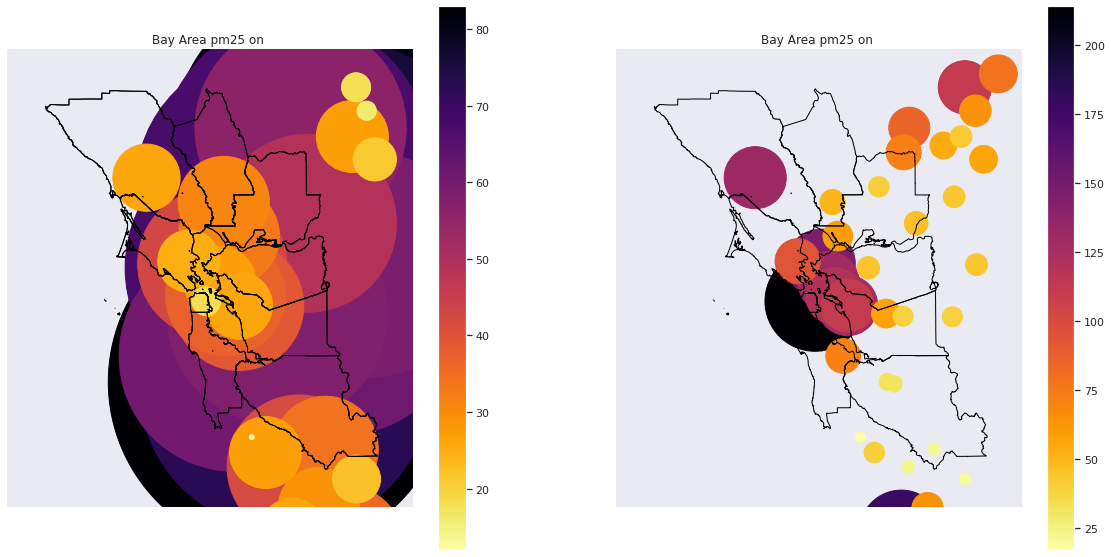

In [27]:
proj = gcrs.AlbersEqualArea(central_latitude=37.8711428, central_longitude=-122.3714777)
fig= plt.figure(figsize=(20, 10))
ax1 = plt.subplot(121, projection=proj)
ax2 = plt.subplot(122, projection=proj)


# gplt.kdeplot(
#     bay_data[['index', 'geometry']],
#     cmap='Reds',
#     projection=proj,
#     shade=True, bw=1,
#     ax=ax1, n_levels=20, weights=bay_data[col_list[1]]
# )
gplt.pointplot(bay_data, projection=proj, hue=col_list[1], legend=True,scale=col_list[1], limits=(0, 341), cmap='inferno_r', ax=ax1, vmin=0, vmax=340)
gplt.polyplot(world, zorder=1, ax=ax1)
ax1.axis(xmin=-50000,xmax=60000, ymin=-60000, ymax=50000)
ax1.set_title("Bay Area pm25 on ")

# gplt.kdeplot(
#     bay_data[['index', 'geometry']],
#     cmap='Reds',
#     projection=proj,
#     shade=True, bw=1,
#     ax=ax2, n_levels=20, weights=bay_data[dark_max[0]]
# )
gplt.pointplot(bay_data, projection=proj, hue=dark_max[0], legend=True,scale=dark_max[0], limits=(10, 100), cmap='inferno_r', ax=ax2)
gplt.polyplot(world, zorder=1, ax=ax1)
# ax1.axis(xmin=-50000,xmax=60000, ymin=-70000, ymax=50000)
ax1.set_title("Bay Area pm25 on ")
gplt.polyplot(world, zorder=1, ax=ax2)
# ax2.axis(xmin=-50000,xmax=60000, ymin=-70000, ymax=50000)
ax2.set_title("Bay Area pm25 on ")

<Figure size 432x288 with 0 Axes>

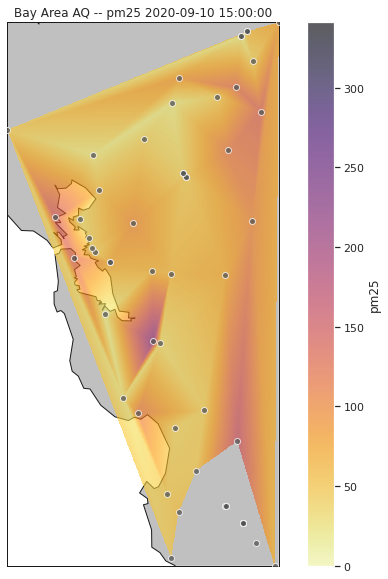

In [28]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline


def aqviz(coords, val,param):
    # https://stackoverflow.com/questions/26872337/how-can-i-get-my-contour-plot-superimposed-on-a-basemap
    # set up plot
    plt.clf()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, frame_on=False)

    # grab data
    data['Z'] = bay_data[val]

    norm = Normalize()

    # define map extent
    lllon = min(data.Lon.values)
    lllat = min(data.Lat.values)
    urlon = max(data.Lon.values)
    urlat = max(data.Lat.values)


    # Set up Basemap instance
    m = Basemap(
        projection = 'merc',
        llcrnrlon = lllon, llcrnrlat = lllat, urcrnrlon = urlon, urcrnrlat = urlat,
        resolution='i')

    # transform lon / lat coordinates to map projection
    data['projected_lon'], data['projected_lat'] = m(*(data.Lon.values, data.Lat.values))

    # # grid data
    numcols, numrows = 1000, 1000
    xi = np.linspace(data['projected_lon'].min(), data['projected_lon'].max(), numcols)
    yi = np.linspace(data['projected_lat'].min(), data['projected_lat'].max(), numrows)
    xi, yi = np.meshgrid(xi, yi)

    # # interpolate
    x, y, z = data['projected_lon'].values, data['projected_lat'].values, data.Z.values
    zi = griddata((x, y), z, (xi, yi))

    # # draw map details
    m.drawmapboundary(fill_color = 'white')
    m.fillcontinents(color='#C0C0C0', lake_color='#7093DB')
    m.drawcountries(
        linewidth=.75, linestyle='solid', color='#000073',
        antialiased=True,
        ax=ax, zorder=3)
    m.drawcoastlines()


    # # contour plot
    con = m.pcolormesh(xi, yi, zi, zorder=20, alpha=0.6, cmap='inferno_r', vmin=0, vmax=341)
    # scatter plot
    m.scatter(
        data['projected_lon'],
        data['projected_lat'],
        color='#545454',
        edgecolor='#ffffff',
        alpha=.75,
        ax=ax,
        vmin=zi.min(), vmax=zi.max(), zorder=20)

    # # add colour bar and title
    # # add colour bar, title, and scale
    cbar = plt.colorbar(orientation='vertical', fraction=.057, pad=0.05)
    if param == 'pm25':
        cbar.set_label("pm25")
    plt.title("Bay Area AQ -- " + param + " " + str(val))
    # m.drawmapscale(
    #     24., -9., 28., -13,
    #     100,
    #     units='km', fontsize=10,
    #     yoffset=None,
    #     barstyle='fancy', labelstyle='simple',
    #     fillcolor1='w', fillcolor2='#000000',
    #     fontcolor='#000000',
    #     zorder=5)

aqviz(data, dark_max[0], 'pm25')


In [34]:
## Need to make this into a function!

# filenames = []
# for i in range(1,110):
#     # plot the line chart
#     # aqviz(data, col_list[i], 'pm25')
    
#     # create file name and append it to a list
#     filename = f'figures/fig_{i}.png'
#     filenames.append(filename)
    
    # save frame
    # plt.savefig(filename)
    # plt.close()
    
# with imageio.get_writer('figures/mygif.gif', mode='I') as writer:
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)
        
# for filename in set(filenames):
#     os.remove(filename)

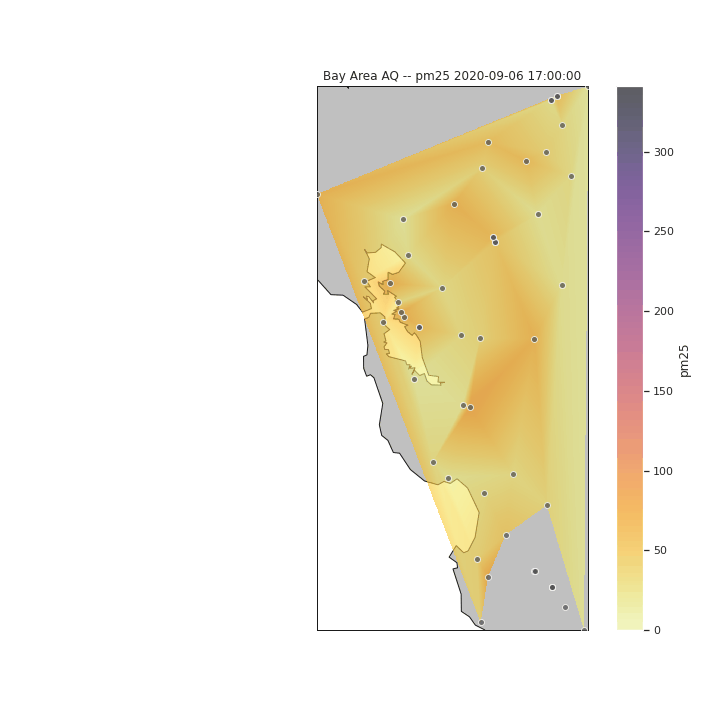

In [39]:
import IPython
path_to_gif = "figures/mygif.gif"
from IPython.core.display import Image
Image(filename=path_to_gif)


/home/jovyan/envs/aqproject/lib/python3.10/site-packages/geoplot/geoplot.py:248: UserWarning: Please specify "legend_var" explicitly when both "hue" and "scale" are specified. Defaulting to "legend_var='hue'".
  warnings.warn(


Text(0.5, 1.0, 'Bay Area pm25 on ')

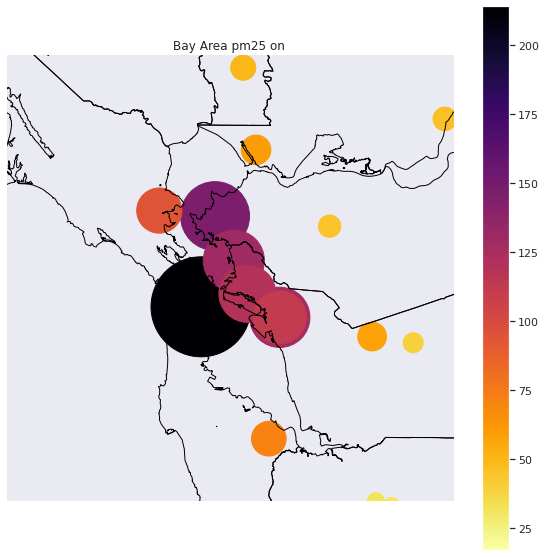

In [30]:
proj = gcrs.AlbersEqualArea(central_latitude=37.8711428, central_longitude=-122.3714777)
fig= plt.figure(figsize=(10, 10))
ax1 = plt.subplot(111, projection=proj)

gplt.pointplot(bay_data, projection=proj, hue=dark_max[0], legend=True,scale=dark_max[0], limits=(10, 100), cmap='inferno_r', ax=ax1)
# gplt.kdeplot(
#     bay_data[['index',col_list[1], 'geometry']],
#     cmap='Reds',
#     projection=proj,
#     shade=True,
#     ax=ax1, n_levels=20
# )
gplt.polyplot(world, zorder=1, ax=ax1)
ax1.axis(xmin=-50000,xmax=60000, ymin=-60000, ymax=50000)
ax1.set_title("Bay Area pm25 on ")

In [31]:
bay_data[['index',col_list[1], 'geometry']]

index  2020-09-06 17:00:00                     geometry
0               Woodland                 56.0  POINT (-121.73268 38.66124)
1              Vacaville                 68.0  POINT (-121.94985 38.35656)
2                 Auburn                 12.0  POINT (-121.09959 38.93568)
3              Rio Vista                 49.0  POINT (-121.68856 38.16730)
4                TracyAP                 61.0  POINT (-121.44060 37.68250)
5     Davis - UCD Campus                 67.4  POINT (-121.77340 38.53455)
6    Gilory - 9th Street                 34.0  POINT (-121.57468 36.99957)
7   Arden Arcade - Del P                 27.0  POINT (-121.36801 38.61380)
8          Laney College                 37.0  POINT (-122.26338 37.79362)
9     Livermore - Rincon                 71.0  POINT (-121.78422 37.68753)
10               Vallejo                 33.0  POINT (-122.23798 38.10251)
11           Sloughhouse                 21.0  POINT (-121.21113 38.49448)
12            Sebastopol                 26.0  POINT (-122.81829 38.40376)
13               Concord                 68.0  POINT (-122.02500 37.93830)
14            San Rafael                 25.0  POINT (-122.51890 37.97220)
15   San Pablo - Rumrill                 43.0  POINT (-122.35710 37.96040)
16   San Jose - Knox Ave                 73.0  POINT (-121.84989 37.33820)
17  San Jose - Jackson S                 83.0  POINT (-121.89470 37.34830)
18         San Francisco                 18.0  POINT (-122.39780 37.76580)
19               Oakland                 39.0  POINT (-122.16991 37.74306)
20          Oakland West                 26.0  POINT (-122.16991 37.74306)
21          Redwood City                 60.0  POINT (-122.20220 37.48280)
22             Elk Grove                 76.0  POINT (-121.42084 38.30259)
23  SLV Middle School AM                 13.0  POINT (-122.08309 37.06315)
24               Lincoln                 18.0  POINT (-121.33835 38.86794)
25         King City AMS                 27.0  POINT (-121.12637 36.20929)
26         Hollister AMS                 22.0  POINT (-121.36210 36.84343)
27  Pleasanton - Owens C                 58.0  POINT (-121.90302 37.70122)
28  Roseville - N.Sunris                 16.0  POINT (-121.26498 38.74643)
29     Carmel Valley AMS                 31.0  POINT (-121.73333 36.48187)
30           Salinas AMS                 29.0  POINT (-121.62327 36.69426)
31        Santa Cruz AMS                 27.0  POINT (-121.98822 36.98332)
32   Downtown Sacramento                 80.0  POINT (-121.49311 38.56844)
33      Rio Vista_658164                 49.0  POINT (-121.68856 38.16730)
34        Lincoln_201303                 18.0  POINT (-121.33835 38.86794)
35   Stockton - Hazelton                 59.0  POINT (-121.26897 37.95075)
36  Berkeley Aquatic Par                 27.0  POINT (-122.30274 37.86477)
37  Napa - Napa Valley C                 31.0  POINT (-122.27502 38.27885)
38  MBARD Office - Monte                 26.0  POINT (-121.80492 36.57272)
39           Watsonville                 42.0  POINT (-121.75675 36.90800)
40  Big Sur Ranger Stati                 19.0  POINT (-121.78132 36.24781)
41               Soledad                 29.0  POINT (-121.32782 36.42798)
42            Greenfield                 15.0  POINT (-121.24582 36.32697)
43              Gonzales                 36.0  POINT (-121.44279 36.51194)
44        Soledad_299337                 29.0  POINT (-121.32782 36.42798)
45       Gonzales_895793                 36.0  POINT (-121.44279 36.51194)

In [32]:
bay_data[['index',dark_max[0], 'geometry']]

index  2020-09-10 15:00:00                     geometry
0               Woodland            85.000000  POINT (-121.73268 38.66124)
1              Vacaville            40.000000  POINT (-121.94985 38.35656)
2                 Auburn            78.000000  POINT (-121.09959 38.93568)
3              Rio Vista            46.000000  POINT (-121.68856 38.16730)
4                TracyAP            39.000000  POINT (-121.44060 37.68250)
5     Davis - UCD Campus            71.800000  POINT (-121.77340 38.53455)
6    Gilory - 9th Street            21.000000  POINT (-121.57468 36.99957)
7   Arden Arcade - Del P            42.333333  POINT (-121.36801 38.61380)
8          Laney College           120.000000  POINT (-122.26338 37.79362)
9     Livermore - Rincon            39.000000  POINT (-121.78422 37.68753)
10               Vallejo            60.000000  POINT (-122.23798 38.10251)
11           Sloughhouse            56.000000  POINT (-121.21113 38.49448)
12            Sebastopol           131.000000  POINT (-122.81829 38.40376)
13               Concord            44.000000  POINT (-122.02500 37.93830)
14            San Rafael            94.000000  POINT (-122.51890 37.97220)
15   San Pablo - Rumrill           146.000000  POINT (-122.35710 37.96040)
16   San Jose - Knox Ave            31.000000  POINT (-121.84989 37.33820)
17  San Jose - Jackson S            32.000000  POINT (-121.89470 37.34830)
18         San Francisco           214.000000  POINT (-122.39780 37.76580)
19               Oakland           127.000000  POINT (-122.16991 37.74306)
20          Oakland West           111.000000  POINT (-122.16991 37.74306)
21          Redwood City            71.000000  POINT (-122.20220 37.48280)
22             Elk Grove            42.666667  POINT (-121.42084 38.30259)
23  SLV Middle School AM            17.000000  POINT (-122.08309 37.06315)
24               Lincoln           111.000000  POINT (-121.33835 38.86794)
25         King City AMS            26.000000  POINT (-121.12637 36.20929)
26         Hollister AMS            20.000000  POINT (-121.36210 36.84343)
27  Pleasanton - Owens C            58.000000  POINT (-121.90302 37.70122)
28  Roseville - N.Sunris            64.000000  POINT (-121.26498 38.74643)
29     Carmel Valley AMS           158.000000  POINT (-121.73333 36.48187)
30           Salinas AMS            64.000000  POINT (-121.62327 36.69426)
31        Santa Cruz AMS            40.000000  POINT (-121.98822 36.98332)
32   Downtown Sacramento            54.000000  POINT (-121.49311 38.56844)
33      Rio Vista_658164            46.000000  POINT (-121.68856 38.16730)
34        Lincoln_201303           111.000000  POINT (-121.33835 38.86794)
35   Stockton - Hazelton            43.000000  POINT (-121.26897 37.95075)
36  Berkeley Aquatic Par           129.000000  POINT (-122.30274 37.86477)
37  Napa - Napa Valley C            50.000000  POINT (-122.27502 38.27885)
38  MBARD Office - Monte           178.000000  POINT (-121.80492 36.57272)
39           Watsonville            23.000000  POINT (-121.75675 36.90800)
40  Big Sur Ranger Stati            99.000000  POINT (-121.78132 36.24781)
41               Soledad            39.000000  POINT (-121.32782 36.42798)
42            Greenfield            22.000000  POINT (-121.24582 36.32697)
43              Gonzales            46.000000  POINT (-121.44279 36.51194)
44        Soledad_299337            39.000000  POINT (-121.32782 36.42798)
45       Gonzales_895793            46.000000  POINT (-121.44279 36.51194)